In [1]:
import typing
import numpy as np
import pandas as pd
import interpretable as inter
import interpretable_linear_data as interData
import tqdm.auto as tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow.python.eager import context

tf.config.threading.set_inter_op_parallelism_threads(5)
_ = tf.Variable([1])

import DeepLearningInterpretable as DLI

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.constraints import NonNeg 

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

from scipy.optimize import curve_fit
from pandas import Grouper as tg

scaler = StandardScaler()

In [3]:
def plot_kernels(kernels, ax):
    for kernel in kernels: 
        ax.plot(kernels[kernel][1:], label = 'kernel approx with kernel:'+str(kernel))
        ax.set_title('regressed kernel ')
        ax.set_xlabel('t')
        ax.set_ylabel('Price ($)')
        ax.set_xlim((1,500))
        ax.legend()
        
def plot_loss(ax, history):
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    ax.set_title('model loss')
    ax.set_ylabel('loss')
    ax.set_xlabel('epoch')
    ax.legend(['train', 'test'], loc='upper right')
    
def curve_fittingPL(v,a,b):
    return a*np.power(v,-b)

def curve_fittingExpo(v,a,b):
    return a*np.power(v,-b)


$\underline{\text{Data Loading:}}$

In [4]:
# load clean data
%store -r dfSPMINI
%store -r dfUST
#dfSPMINI = pd.read_csv('dfSPMINI.csv')
#dfSPMINI = pd.read_csv('dfUST.csv')

dfSPMINI = dfSPMINI.head(3000000)

dfSPMINI['sign'] = dfSPMINI['qty_signed'].apply(lambda x: np.sign(x))
dfUST['sign'] = dfUST['qty_signed'].apply(lambda x: np.sign(x))

/opt/research-maintainer/cfm/current/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [5]:
# we store the desired data

#SPMINI
mid_SPMINI = dfSPMINI['mid'].copy()

returns_SPMINI = dfSPMINI['returns'].copy()
returns_normalized_SPMINI = dfSPMINI['returns_normalized'].copy()

qty_signed_normalized_SPMINI = dfSPMINI['qty_signed_normalized'].copy()
epsilons_SPMINI = qty_signed_normalized_SPMINI.apply(lambda x: np.sign(x)).copy()
qty_signed_SPMINI = dfSPMINI['qty'].multiply(epsilons_SPMINI)

#UST
mid_UST = dfUST['mid'].copy()

returns_UST = dfUST['returns'].copy()
returns_normalized_UST = dfUST['returns_normalized'].copy()

qty_signed_normalized_UST = dfUST['qty_signed_normalized'].copy()
epsilons_UST = qty_signed_normalized_UST.apply(lambda x: np.sign(x)).copy()
qty_signed_UST = dfUST['qty'].multiply(epsilons_UST)

# lengths
N_SPMINI = len(mid_SPMINI)
N_UST = len(mid_UST)

$\underline{\text{Learning quantities:}}$

In [6]:
max_lag = 1000
L = 500

# we define the regression matrix for each method of learning

# SPMINI
A_SPMINI = inter.regression_matrix(qty_signed_normalized_SPMINI.values, L)
A_epsilons_SPMINI = np.sign(A_SPMINI)
Y_SPMINI = returns_normalized_SPMINI.values[L:]

#UST
A_UST = inter.regression_matrix(qty_signed_normalized_UST.values, L)
A_epsilons_UST = np.sign(A_UST)
Y_UST = returns_normalized_UST.values[L:]

In [7]:
#optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1)
#optimizer = tf.optimizers.Adam(learning_rate = 0.0001)
#optimizer = tf.keras.optimizers.Adam(lr = 0.01, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08, decay = 0.001)

optimizer_SPMINI = tf.keras.optimizers.Adam(lr = 0.01, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08, decay = 0.001)
optimizer_UST = tf.keras.optimizers.Adam(lr = 0.01, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08, decay = 0.001)
batch_size_SPMINI = int(N_SPMINI/10000)
batch_size_UST = int(N_UST/10000)
callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 5)

$\underline{\text{One kernel + power law impact function:}}$

In [8]:
OneKernelPowerLaw_SPMINI, historyOneKernelPowerLaw_SPMINI = DLI.modelPowerLaw(A_SPMINI, Y_SPMINI, optimizer_SPMINI, batch_size_SPMINI, epochs = 200)
OneKernelPowerLaw_UST, historyOneKernelPowerLaw_UST = DLI.modelPowerLaw(A_UST, Y_UST, optimizer_UST, batch_size_UST, epochs = 200)

Epoch 1/200
6999/6999 [==============================] - 20s 3ms/step - loss: 0.9717 - val_loss: 0.8023
Epoch 2/200
6999/6999 [==============================] - 17s 2ms/step - loss: 0.9537 - val_loss: 0.7976
Epoch 3/200
6999/6999 [==============================] - 17s 2ms/step - loss: 0.9504 - val_loss: 0.7941
Epoch 4/200
6999/6999 [==============================] - 17s 2ms/step - loss: 0.9490 - val_loss: 0.7934
Epoch 5/200
6999/6999 [==============================] - 17s 2ms/step - loss: 0.9482 - val_loss: 0.7924
Epoch 6/200
6999/6999 [==============================] - 17s 2ms/step - loss: 0.9478 - val_loss: 0.7921
Epoch 7/200
6999/6999 [==============================] - 17s 2ms/step - loss: 0.9474 - val_loss: 0.7915
Epoch 8/200
6999/6999 [==============================] - 17s 2ms/step - loss: 0.9471 - val_loss: 0.7913
Epoch 9/200
6999/6999 [==============================] - 17s 2ms/step - loss: 0.9469 - val_loss: 0.7913
Epoch 10/200
6999/6999 [==============================] - 17s 2m

6999/6999 [==============================] - 19s 3ms/step - loss: 0.9455 - val_loss: 0.7904
Epoch 80/200
6999/6999 [==============================] - 19s 3ms/step - loss: 0.9455 - val_loss: 0.7904
Epoch 81/200
6999/6999 [==============================] - 19s 3ms/step - loss: 0.9455 - val_loss: 0.7903
Epoch 82/200
6999/6999 [==============================] - 19s 3ms/step - loss: 0.9455 - val_loss: 0.7903
Epoch 83/200
6999/6999 [==============================] - 19s 3ms/step - loss: 0.9455 - val_loss: 0.7904
Epoch 84/200
6999/6999 [==============================] - 19s 3ms/step - loss: 0.9455 - val_loss: 0.7904
Epoch 85/200
6999/6999 [==============================] - 20s 3ms/step - loss: 0.9455 - val_loss: 0.7903
Epoch 86/200
6999/6999 [==============================] - 19s 3ms/step - loss: 0.9455 - val_loss: 0.7904
Epoch 87/200
6999/6999 [==============================] - 19s 3ms/step - loss: 0.9455 - val_loss: 0.7904
Epoch 88/200
6999/6999 [==============================] - 19s 3ms/st

6999/6999 [==============================] - 19s 3ms/step - loss: 0.9454 - val_loss: 0.7904
Epoch 157/200
6999/6999 [==============================] - 19s 3ms/step - loss: 0.9454 - val_loss: 0.7904
Epoch 158/200
6999/6999 [==============================] - 18s 3ms/step - loss: 0.9454 - val_loss: 0.7903
Epoch 159/200
6999/6999 [==============================] - 18s 3ms/step - loss: 0.9454 - val_loss: 0.7903
Epoch 160/200
6999/6999 [==============================] - 18s 3ms/step - loss: 0.9454 - val_loss: 0.7903
Epoch 161/200
6999/6999 [==============================] - 18s 3ms/step - loss: 0.9454 - val_loss: 0.7904
Epoch 162/200
6999/6999 [==============================] - 18s 3ms/step - loss: 0.9454 - val_loss: 0.7903
Epoch 163/200
6999/6999 [==============================] - 18s 3ms/step - loss: 0.9454 - val_loss: 0.7903
Epoch 164/200
6999/6999 [==============================] - 18s 3ms/step - loss: 0.9454 - val_loss: 0.7903
Epoch 165/200
6999/6999 [==============================] - 1

Epoch 28/200
6997/6997 [==============================] - 12s 2ms/step - loss: 0.9112 - val_loss: 0.8861
Epoch 29/200
6997/6997 [==============================] - 12s 2ms/step - loss: 0.9112 - val_loss: 0.8863
Epoch 30/200
6997/6997 [==============================] - 12s 2ms/step - loss: 0.9112 - val_loss: 0.8862
Epoch 31/200
6997/6997 [==============================] - 13s 2ms/step - loss: 0.9111 - val_loss: 0.8861
Epoch 32/200
6997/6997 [==============================] - 13s 2ms/step - loss: 0.9111 - val_loss: 0.8860
Epoch 33/200
6997/6997 [==============================] - 12s 2ms/step - loss: 0.9111 - val_loss: 0.8861
Epoch 34/200
6997/6997 [==============================] - 12s 2ms/step - loss: 0.9111 - val_loss: 0.8861
Epoch 35/200
6997/6997 [==============================] - 13s 2ms/step - loss: 0.9111 - val_loss: 0.8861
Epoch 36/200
6997/6997 [==============================] - 12s 2ms/step - loss: 0.9111 - val_loss: 0.8860
Epoch 37/200
6997/6997 [==============================]

Epoch 106/200
6997/6997 [==============================] - 13s 2ms/step - loss: 0.9106 - val_loss: 0.8860
Epoch 107/200
6997/6997 [==============================] - 13s 2ms/step - loss: 0.9106 - val_loss: 0.8860
Epoch 108/200
6997/6997 [==============================] - 12s 2ms/step - loss: 0.9106 - val_loss: 0.8860
Epoch 109/200
6997/6997 [==============================] - 12s 2ms/step - loss: 0.9106 - val_loss: 0.8860
Epoch 110/200
6997/6997 [==============================] - 12s 2ms/step - loss: 0.9106 - val_loss: 0.8860
Epoch 111/200
6997/6997 [==============================] - 12s 2ms/step - loss: 0.9106 - val_loss: 0.8860
Epoch 112/200
6997/6997 [==============================] - 12s 2ms/step - loss: 0.9106 - val_loss: 0.8860
Epoch 113/200
6997/6997 [==============================] - 13s 2ms/step - loss: 0.9106 - val_loss: 0.8860
Epoch 114/200
6997/6997 [==============================] - 12s 2ms/step - loss: 0.9105 - val_loss: 0.8860
Epoch 115/200
6997/6997 [=====================

6997/6997 [==============================] - 13s 2ms/step - loss: 0.9105 - val_loss: 0.8860
Epoch 184/200
6997/6997 [==============================] - 12s 2ms/step - loss: 0.9105 - val_loss: 0.8860
Epoch 185/200
6997/6997 [==============================] - 12s 2ms/step - loss: 0.9105 - val_loss: 0.8860
Epoch 186/200
6997/6997 [==============================] - 13s 2ms/step - loss: 0.9105 - val_loss: 0.8860
Epoch 187/200
6997/6997 [==============================] - 13s 2ms/step - loss: 0.9105 - val_loss: 0.8860
Epoch 188/200
6997/6997 [==============================] - 12s 2ms/step - loss: 0.9105 - val_loss: 0.8860
Epoch 189/200
6997/6997 [==============================] - 12s 2ms/step - loss: 0.9105 - val_loss: 0.8860
Epoch 190/200
6997/6997 [==============================] - 12s 2ms/step - loss: 0.9105 - val_loss: 0.8860
Epoch 191/200
6997/6997 [==============================] - 12s 2ms/step - loss: 0.9105 - val_loss: 0.8860
Epoch 192/200
6997/6997 [==============================] - 1

In [9]:
GNNPL_approx_SPMINI = pd.concat((pd.Series([0]), pd.Series(OneKernelPowerLaw_SPMINI.layers[1].kernel.numpy().cumsum())))
GNNPL_approx_UST = pd.concat((pd.Series([0]), pd.Series(OneKernelPowerLaw_UST.layers[1].kernel.numpy().cumsum())))

%store GNNPL_approx_SPMINI
%store GNNPL_approx_UST

Stored 'GNNPL_approx_SPMINI' (Series)
Stored 'GNNPL_approx_UST' (Series)


In [10]:
params1, cov = curve_fit(curve_fittingPL, np.arange(1,L+2), GNNPL_approx_SPMINI[1:] )
appro1 = curve_fittingPL(np.arange(1,L+1), *params1)

params2, cov = curve_fit(curve_fittingPL, np.arange(1,L+2), GNNPL_approx_UST[1:] )
appro2 = curve_fittingPL(np.arange(1,L+1), *params2)

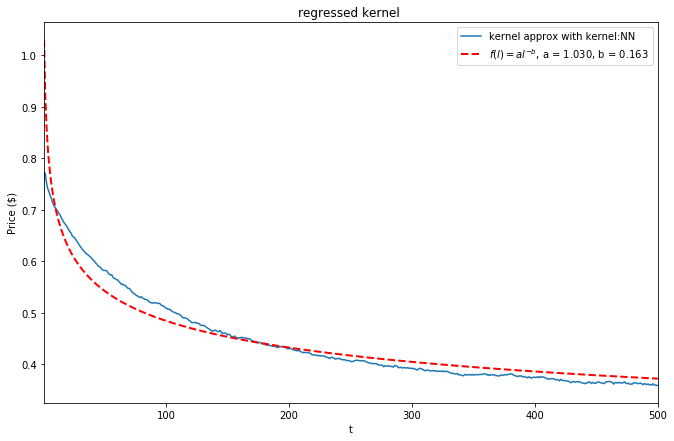

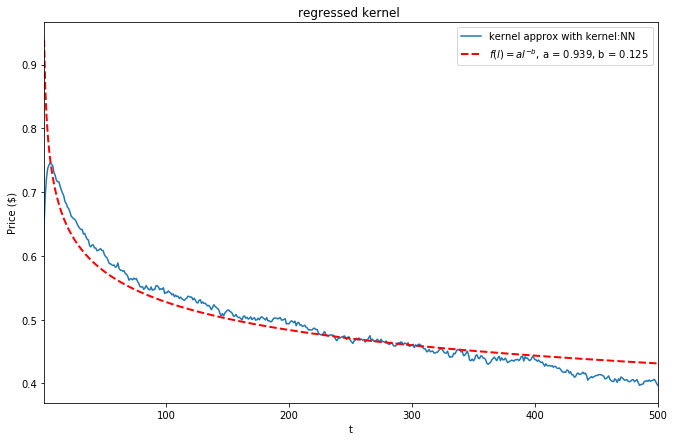

In [11]:
kernels = {'NN': GNNPL_approx_SPMINI}
fig, (ax) = plt.subplots(1, 1, figsize = [11, 7])
plot_kernels(kernels, ax)
ax.plot(np.arange(1,L+1), appro1[:L+1], '--r', linewidth=2, 
label = r'$f(l) = al^{-b}$' + ', a = ' + str(params1[0])[:5] + ', b = ' + str(params1[1])[:5] )
ax.legend()

kernels = {'NN': GNNPL_approx_UST}
fig, (ax) = plt.subplots(1, 1, figsize = [11, 7])
plot_kernels(kernels, ax)
ax.plot(np.arange(1,L+1), appro2[:L+1], '--r', linewidth=2, 
label = r'$f(l) = al^{-b}$' + ', a = ' + str(params2[0])[:5] + ', b = ' + str(params2[1])[:5] )
ax.legend()



In [12]:
alphaGNNPL_SPMINI = OneKernelPowerLaw_SPMINI.layers[0].kernel.numpy()[0]
alphaGNNPL_UST = OneKernelPowerLaw_UST.layers[0].kernel.numpy()[0]
%store alphaGNNPL_SPMINI
%store alphaGNNPL_UST

Stored 'alphaGNNPL_SPMINI' (float32)
Stored 'alphaGNNPL_UST' (float32)


In [13]:
returnsapproxGNNPL_SPMINI = OneKernelPowerLaw_SPMINI.predict(A_SPMINI)
returnsapproxGNNPL_UST = OneKernelPowerLaw_UST.predict(A_UST)
% store returnsapproxGNNPL_SPMINI
% store returnsapproxGNNPL_UST

R2_PowerModelGNNPL_SPMINI = r2_score(Y_SPMINI, returnsapproxGNNPL_SPMINI)
print('R^2 train (returns): %.3f' % R2_PowerModelGNNPL_SPMINI )

R2_PowerModelGNNPL_UST = r2_score(Y_UST, returnsapproxGNNPL_UST)
print('R^2 train (returns): %.3f' % R2_PowerModelGNNPL_UST )

% store R2_PowerModelGNNPL_SPMINI
% store R2_PowerModelGNNPL_UST

Stored 'returnsapproxGNNPL_SPMINI' (ndarray)
Stored 'returnsapproxGNNPL_UST' (ndarray)
R^2 train (returns): 0.175
R^2 train (returns): 0.097
Stored 'R2_PowerModelGNNPL_SPMINI' (float64)
Stored 'R2_PowerModelGNNPL_UST' (float64)



Stored 'synthetic_variogram_GNNPL_approx_SPMINI' (Series)
Stored 'synthetic_variogram_GNNPL_approx_UST' (Series)


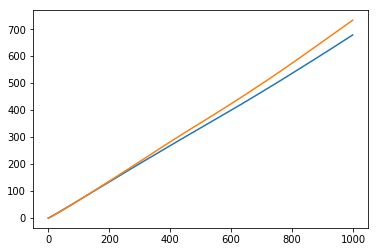

In [14]:
synthetic_variogram_GNNPL_approx_SPMINI = inter.variogram2(returnsapproxGNNPL_SPMINI.cumsum())
synthetic_variogram_GNNPL_approx_UST = inter.variogram2(returnsapproxGNNPL_UST.cumsum())
plt.plot(synthetic_variogram_GNNPL_approx_SPMINI)
plt.plot(synthetic_variogram_GNNPL_approx_UST)
% store synthetic_variogram_GNNPL_approx_SPMINI
% store synthetic_variogram_GNNPL_approx_UST

$\underline{\text{Two kernels + power law impact function:}}$

In [15]:
# we create a new matrix. We concatenate the qty signed matrix with the sign matrix 
new_matrix_SPMINI = np.concatenate((A_SPMINI,A_SPMINI), axis = 1)
new_matrix_UST = np.concatenate((A_UST,A_UST), axis = 1)

In [16]:
TwoKernelsDoublePowerLaw_SPMINI, historyTwoKernelsDoublePowerLaw_SPMINI = DLI.modelDoublePowerLaw(new_matrix_SPMINI, Y_SPMINI, optimizer_SPMINI, batch_size_SPMINI, epochs = 200)
TwoKernelsDoublePowerLaw_UST, historyTwoKernelsDoublePowerLaw_UST  = DLI.modelDoublePowerLaw(new_matrix_UST, Y_UST, optimizer_UST, batch_size_UST, epochs = 200)

Epoch 1/200
6999/6999 [==============================] - 38s 5ms/step - loss: 38.0699 - val_loss: 32.9255
Epoch 2/200
6999/6999 [==============================] - 32s 5ms/step - loss: 30.7676 - val_loss: 25.7515
Epoch 3/200
6999/6999 [==============================] - 34s 5ms/step - loss: 24.9272 - val_loss: 20.0158
Epoch 4/200
6999/6999 [==============================] - 32s 5ms/step - loss: 19.9963 - val_loss: 15.2036
Epoch 5/200
6999/6999 [==============================] - 33s 5ms/step - loss: 16.0449 - val_loss: 11.7853
Epoch 6/200
6999/6999 [==============================] - 32s 5ms/step - loss: 13.1744 - val_loss: 9.3667
Epoch 7/200
6999/6999 [==============================] - 33s 5ms/step - loss: 10.9313 - val_loss: 7.3294
Epoch 8/200
6999/6999 [==============================] - 32s 5ms/step - loss: 9.0999 - val_loss: 5.8096
Epoch 9/200
6999/6999 [==============================] - 34s 5ms/step - loss: 7.5911 - val_loss: 4.6668
Epoch 10/200
6999/6999 [============================

Epoch 79/200
6999/6999 [==============================] - 32s 5ms/step - loss: 0.9663 - val_loss: 0.7863
Epoch 80/200
6999/6999 [==============================] - 32s 5ms/step - loss: 0.9664 - val_loss: 0.7863
Epoch 81/200
6999/6999 [==============================] - 32s 5ms/step - loss: 0.9664 - val_loss: 0.7863
Epoch 82/200
6999/6999 [==============================] - 32s 5ms/step - loss: 0.9660 - val_loss: 0.7863
Epoch 83/200
6999/6999 [==============================] - 32s 5ms/step - loss: 0.9663 - val_loss: 0.7863
Epoch 84/200
6999/6999 [==============================] - 31s 4ms/step - loss: 0.9661 - val_loss: 0.7863
Epoch 85/200
6999/6999 [==============================] - 31s 4ms/step - loss: 0.9661 - val_loss: 0.7863
Epoch 86/200
6999/6999 [==============================] - 32s 5ms/step - loss: 0.9662 - val_loss: 0.7863
Epoch 87/200
6999/6999 [==============================] - 32s 5ms/step - loss: 0.9661 - val_loss: 0.7863
Epoch 88/200
6999/6999 [==============================]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6999/6999 [==============================] - 31s 4ms/step - loss: 0.9662 - val_loss: 0.7863
Epoch 147/200
6999/6999 [==============================] - 31s 4ms/step - loss: 0.9662 - val_loss: 0.7863
Epoch 148/200
6999/6999 [==============================] - 31s 4ms/step - loss: 0.9662 - val_loss: 0.7862
Epoch 149/200
6999/6999 [==============================] - 31s 4ms/step - loss: 0.9664 - val_loss: 0.7863
Epoch 150/200
6999/6999 [==============================] - 33s 5ms/step - loss: 0.9662 - val_loss: 0.7863
Epoch 151/200
6999/6999 [==============================] - 33s 5ms/step - loss: 0.9661 - val_loss: 0.7863
Epoch 152/200
6999/6999 [==============================] - 32s 5ms/step - loss: 0.9662 - val_loss: 0.7863
Epoch 153/200
 533/6999 [=>............................] - ETA: 23s - loss: 0.9595

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6999/6999 [==============================] - 33s 5ms/step - loss: 0.9663 - val_loss: 0.7863
Epoch 176/200
6999/6999 [==============================] - 34s 5ms/step - loss: 0.9660 - val_loss: 0.7863
Epoch 177/200
6999/6999 [==============================] - 34s 5ms/step - loss: 0.9661 - val_loss: 0.7863
Epoch 178/200
6999/6999 [==============================] - 33s 5ms/step - loss: 0.9657 - val_loss: 0.7863
Epoch 179/200
6999/6999 [==============================] - 33s 5ms/step - loss: 0.9666 - val_loss: 0.7863
Epoch 180/200
6999/6999 [==============================] - 32s 5ms/step - loss: 0.9669 - val_loss: 0.7863
Epoch 181/200
 248/6999 [>.............................] - ETA: 24s - loss: 0.9735

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6997/6997 [==============================] - 19s 3ms/step - loss: 87.1129 - val_loss: 62.6292
Epoch 2/200
6997/6997 [==============================] - 17s 2ms/step - loss: 68.4652 - val_loss: 49.1022
Epoch 3/200
6997/6997 [==============================] - 17s 2ms/step - loss: 55.6918 - val_loss: 41.1711
Epoch 4/200
6997/6997 [==============================] - 18s 3ms/step - loss: 48.1531 - val_loss: 35.8020
Epoch 5/200
6997/6997 [==============================] - 18s 3ms/step - loss: 42.2888 - val_loss: 31.3446
Epoch 6/200
6997/6997 [==============================] - 18s 3ms/step - loss: 38.1154 - val_loss: 28.0833
Epoch 7/200
6997/6997 [==============================] - 17s 2ms/step - loss: 34.5044 - val_loss: 24.9288
Epoch 8/200
6997/6997 [==============================] - 18s 3ms/step - loss: 31.4405 - val_loss: 22.6270
Epoch 9/200
6997/6997 [==============================] - 20s 3ms/step - loss: 28.6623 - val_loss: 20.1655
Epoch 10/200
6997/6997 [==============================] - 

Epoch 79/200
6997/6997 [==============================] - 17s 2ms/step - loss: 0.9676 - val_loss: 0.8859
Epoch 80/200
6997/6997 [==============================] - 17s 2ms/step - loss: 0.9652 - val_loss: 0.8859
Epoch 81/200
6997/6997 [==============================] - 17s 2ms/step - loss: 0.9621 - val_loss: 0.8860
Epoch 82/200
6997/6997 [==============================] - 17s 2ms/step - loss: 0.9582 - val_loss: 0.8860
Epoch 83/200
6997/6997 [==============================] - 17s 2ms/step - loss: 0.9545 - val_loss: 0.8860
Epoch 84/200
6997/6997 [==============================] - 17s 2ms/step - loss: 0.9537 - val_loss: 0.8860
Epoch 85/200
6997/6997 [==============================] - 17s 2ms/step - loss: 0.9508 - val_loss: 0.8860
Epoch 86/200
6997/6997 [==============================] - 17s 2ms/step - loss: 0.9483 - val_loss: 0.8860
Epoch 87/200
6997/6997 [==============================] - 17s 2ms/step - loss: 0.9454 - val_loss: 0.8860
Epoch 88/200
6997/6997 [==============================]

6997/6997 [==============================] - 18s 3ms/step - loss: 0.9190 - val_loss: 0.8864
Epoch 157/200
6997/6997 [==============================] - 18s 3ms/step - loss: 0.9191 - val_loss: 0.8864
Epoch 158/200
6997/6997 [==============================] - 18s 3ms/step - loss: 0.9191 - val_loss: 0.8864
Epoch 159/200
6997/6997 [==============================] - 18s 3ms/step - loss: 0.9191 - val_loss: 0.8864
Epoch 160/200
6997/6997 [==============================] - 18s 3ms/step - loss: 0.9190 - val_loss: 0.8864
Epoch 161/200
6997/6997 [==============================] - 18s 3ms/step - loss: 0.9188 - val_loss: 0.8864
Epoch 162/200
6997/6997 [==============================] - 18s 3ms/step - loss: 0.9195 - val_loss: 0.8864
Epoch 163/200
6997/6997 [==============================] - 18s 3ms/step - loss: 0.9193 - val_loss: 0.8864
Epoch 164/200
6997/6997 [==============================] - 18s 3ms/step - loss: 0.9189 - val_loss: 0.8864
Epoch 165/200
6997/6997 [==============================] - 1

In [17]:
GNNDPL_approx1_SPMINI = pd.concat((pd.Series([0]), pd.Series(TwoKernelsDoublePowerLaw_SPMINI.layers[2].kernel[:L+1].numpy().cumsum())))
GNNDPL_approx2_SPMINI = pd.concat((pd.Series([0]), pd.Series(TwoKernelsDoublePowerLaw_SPMINI.layers[2].kernel[L+1:].numpy().cumsum())))

GNNDPL_approx1_UST = pd.concat((pd.Series([0]), pd.Series(TwoKernelsDoublePowerLaw_UST.layers[2].kernel[:L+1].numpy().cumsum())))
GNNDPL_approx2_UST = pd.concat((pd.Series([0]), pd.Series(TwoKernelsDoublePowerLaw_UST.layers[2].kernel[L+1:].numpy().cumsum())))

%store GNNDPL_approx1_SPMINI
%store GNNDPL_approx2_SPMINI

%store GNNDPL_approx1_UST
%store GNNDPL_approx2_UST

Stored 'GNNDPL_approx1_SPMINI' (Series)
Stored 'GNNDPL_approx2_SPMINI' (Series)
Stored 'GNNDPL_approx1_UST' (Series)
Stored 'GNNDPL_approx2_UST' (Series)


In [18]:
params11, cov = curve_fit(curve_fittingPL, np.arange(1,L+2), GNNDPL_approx1_SPMINI[1:] )
appro11 = curve_fittingPL(np.arange(1,L+1), *params11)
params12, cov = curve_fit(curve_fittingPL, np.arange(1,L+2), GNNDPL_approx2_SPMINI[1:] )
appro12 = curve_fittingPL(np.arange(1,L+1), *params12)

params21, cov = curve_fit(curve_fittingPL, np.arange(1,L+2), GNNDPL_approx1_UST[1:] )
appro21 = curve_fittingPL(np.arange(1,L+1), *params21)
params22, cov = curve_fit(curve_fittingPL, np.arange(1,L+2), GNNDPL_approx2_UST[1:] )
appro22 = curve_fittingPL(np.arange(1,L+1), *params22)

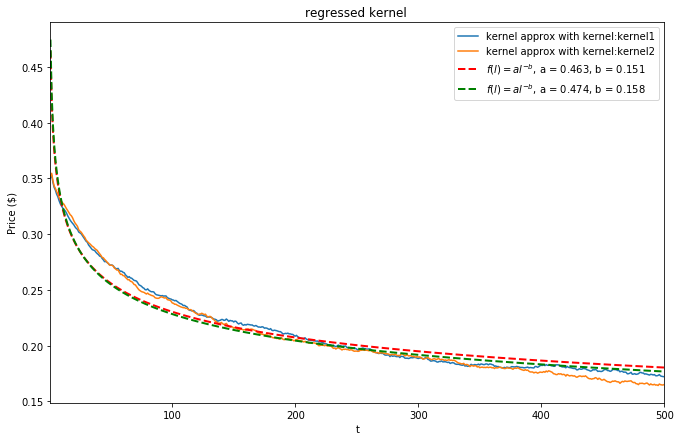

In [19]:
kernels = {'kernel1': GNNDPL_approx1_SPMINI[1:], 'kernel2': GNNDPL_approx2_SPMINI[1:]}
fig, (ax) = plt.subplots(1, 1, figsize = [11, 7])
plot_kernels(kernels, ax)
ax.plot(np.arange(1,L+1), appro11[:L+1], '--r', linewidth=2, 
label = r'$f(l) = al^{-b}$' + ', a = ' + str(params11[0])[:5] + ', b = ' + str(params11[1])[:5] )
ax.legend()
ax.plot(np.arange(1,L+1), appro12[:L+1], '--g', linewidth=2, 
label = r'$f(l) = al^{-b}$' + ', a = ' + str(params12[0])[:5] + ', b = ' + str(params12[1])[:5] )
ax.legend()



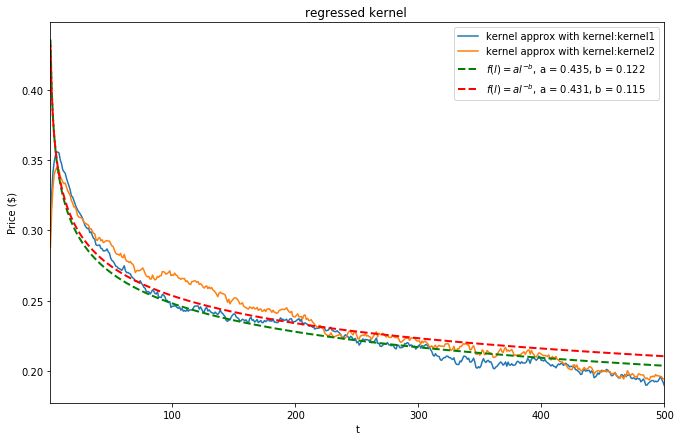

In [20]:
kernels = {'kernel1': GNNDPL_approx1_UST[1:], 'kernel2': GNNDPL_approx2_UST[1:]}
fig, (ax) = plt.subplots(1, 1, figsize = [11, 7])
plot_kernels(kernels, ax)
ax.plot(np.arange(1,L+1), appro21[:L+1], '--g', linewidth=2, 
label = r'$f(l) = al^{-b}$' + ', a = ' + str(params21[0])[:5] + ', b = ' + str(params21[1])[:5] )
ax.legend()
ax.plot(np.arange(1,L+1), appro22[:L+1], '--r', linewidth=2, 
label = r'$f(l) = al^{-b}$' + ', a = ' + str(params22[0])[:5] + ', b = ' + str(params22[1])[:5] )
ax.legend()

In [21]:
alphaGNNDPL_SPMINI = TwoKernelsDoublePowerLaw_SPMINI.layers[0].kernel.numpy()[0]
alphaGNNDPL_UST = TwoKernelsDoublePowerLaw_UST.layers[0].kernel.numpy()[0]
%store alphaGNNDPL_SPMINI
%store alphaGNNDPL_UST

Stored 'alphaGNNDPL_SPMINI' (float32)
Stored 'alphaGNNDPL_UST' (float32)


In [59]:
returnsapproxGNNDPL_SPMINI = TwoKernelsDoublePowerLaw_SPMINI.predict(new_matrix_SPMINI)
returnsapproxGNNDPL_UST = TwoKernelsDoublePowerLaw_UST.predict(new_matrix_UST)
% store returnsapproxGNNDPL_SPMINI
% store returnsapproxGNNDPL_UST

R2_PowerModelGNNDPL_SPMINI = r2_score(Y_SPMINI, returnsapproxGNNDPL_SPMINI)
print('R^2 train (returns): %.3f' % R2_PowerModelGNNDPL_SPMINI )

R2_PowerModelGNNDPL_UST = r2_score(Y_UST, returnsapproxGNNDPL_UST)
print('R^2 train (returns): %.3f' % R2_PowerModelGNNDPL_UST )

% store R2_PowerModelGNNDPL_SPMINI
% store R2_PowerModelGNNDPL_UST

Stored 'returnsapproxGNNDPL_SPMINI' (ndarray)
Stored 'returnsapproxGNNDPL_UST' (ndarray)
R^2 train (returns): 0.175
R^2 train (returns): 0.096
Stored 'R2_PowerModelGNNDPL_SPMINI' (float64)
Stored 'R2_PowerModelGNNDPL_UST' (float64)



Stored 'synthetic_variogram_GNNDPL_approx_SPMINI' (Series)
Stored 'synthetic_variogram_GNNDPL_approx_UST' (Series)


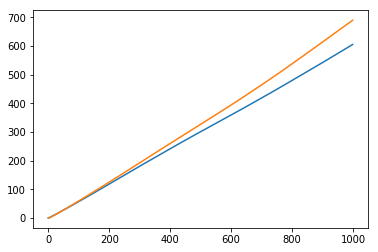

In [23]:
synthetic_variogram_GNNDPL_approx_SPMINI = inter.variogram2(returnsapproxGNNDPL_SPMINI.cumsum())
synthetic_variogram_GNNDPL_approx_UST = inter.variogram2(returnsapproxGNNDPL_UST.cumsum())
% store synthetic_variogram_GNNDPL_approx_SPMINI
% store synthetic_variogram_GNNDPL_approx_UST

plt.plot(synthetic_variogram_GNNDPL_approx_SPMINI)
plt.plot(synthetic_variogram_GNNDPL_approx_UST)

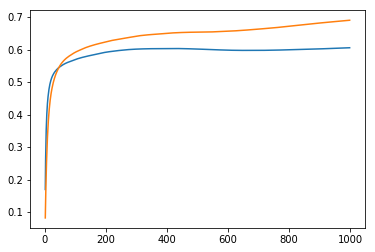

In [24]:
plt.plot(synthetic_variogram_GNNDPL_approx_SPMINI[1:]/np.arange(1,1000))
plt.plot(synthetic_variogram_GNNDPL_approx_UST[1:]/np.arange(1,1000))

In [25]:
% store -r synthetic_variogram_GNNTFPL_approx_SPMINI
% store -r synthetic_variogram_GNNTFPL_approx_UST

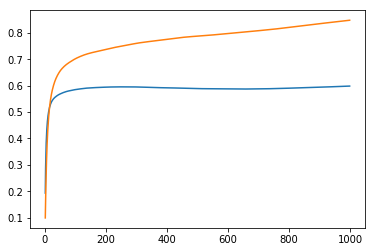

In [26]:
plt.plot(synthetic_variogram_GNNTFPL_approx_SPMINI[1:]/np.arange(1,1000))
plt.plot(synthetic_variogram_GNNTFPL_approx_UST[1:]/np.arange(1,1000))

$\underline{\text{Learning on the residuals:}}$

In [52]:
residuals_SPMINI = returnsapproxGNNPL_SPMINI.reshape(1,-1)[0] - Y_SPMINI
residuals_UST = returnsapproxGNNPL_UST.reshape(1,-1)[0] - Y_UST

In [54]:
OneKernelPowerLaw_SPMINI_residuals, historyOneKernelPowerLaw_SPMINI_res = DLI.modelPowerLaw(A_SPMINI, residuals_SPMINI, optimizer_SPMINI, batch_size_SPMINI, epochs = 200)
OneKernelPowerLaw_UST_residuals, historyOneKernelPowerLaw_UST_res = DLI.modelPowerLaw(A_UST, residuals_UST, optimizer_UST, batch_size_UST, epochs = 200)

Epoch 1/200
6999/6999 [==============================] - 19s 3ms/step - loss: 1.4597 - val_loss: 1.2598
Epoch 2/200
6999/6999 [==============================] - 16s 2ms/step - loss: 1.2908 - val_loss: 1.1064
Epoch 3/200
6999/6999 [==============================] - 17s 2ms/step - loss: 1.1768 - val_loss: 1.0013
Epoch 4/200
6999/6999 [==============================] - 16s 2ms/step - loss: 1.0995 - val_loss: 0.9300
Epoch 5/200
6999/6999 [==============================] - 16s 2ms/step - loss: 1.0477 - val_loss: 0.8832
Epoch 6/200
6999/6999 [==============================] - 16s 2ms/step - loss: 1.0138 - val_loss: 0.8522
Epoch 7/200
6999/6999 [==============================] - 17s 2ms/step - loss: 0.9910 - val_loss: 0.8320
Epoch 8/200
6999/6999 [==============================] - 18s 3ms/step - loss: 0.9762 - val_loss: 0.8183
Epoch 9/200
6999/6999 [==============================] - 18s 3ms/step - loss: 0.9659 - val_loss: 0.8091
Epoch 10/200
6999/6999 [==============================] - 18s 3m

6999/6999 [==============================] - 19s 3ms/step - loss: 0.9451 - val_loss: 0.7897
Epoch 80/200
6999/6999 [==============================] - 19s 3ms/step - loss: 0.9451 - val_loss: 0.7897
Epoch 81/200
6999/6999 [==============================] - 19s 3ms/step - loss: 0.9450 - val_loss: 0.7898
Epoch 82/200
6999/6999 [==============================] - 18s 3ms/step - loss: 0.9450 - val_loss: 0.7898
Epoch 83/200
6999/6999 [==============================] - 18s 3ms/step - loss: 0.9450 - val_loss: 0.7898
Epoch 84/200
6999/6999 [==============================] - 19s 3ms/step - loss: 0.9450 - val_loss: 0.7899
Epoch 85/200
6999/6999 [==============================] - 19s 3ms/step - loss: 0.9451 - val_loss: 0.7897
Epoch 86/200
6999/6999 [==============================] - 19s 3ms/step - loss: 0.9450 - val_loss: 0.7897
Epoch 87/200
6999/6999 [==============================] - 19s 3ms/step - loss: 0.9450 - val_loss: 0.7898
Epoch 88/200
6999/6999 [==============================] - 19s 3ms/st

6999/6999 [==============================] - 19s 3ms/step - loss: 0.9448 - val_loss: 0.7895
Epoch 157/200
6999/6999 [==============================] - 18s 3ms/step - loss: 0.9449 - val_loss: 0.7896
Epoch 158/200
6999/6999 [==============================] - 18s 3ms/step - loss: 0.9448 - val_loss: 0.7897
Epoch 159/200
6999/6999 [==============================] - 19s 3ms/step - loss: 0.9448 - val_loss: 0.7897
Epoch 160/200
6999/6999 [==============================] - 19s 3ms/step - loss: 0.9448 - val_loss: 0.7897
Epoch 161/200
6999/6999 [==============================] - 19s 3ms/step - loss: 0.9450 - val_loss: 0.7895
Epoch 162/200
6999/6999 [==============================] - 19s 3ms/step - loss: 0.9449 - val_loss: 0.7895
Epoch 163/200
6999/6999 [==============================] - 19s 3ms/step - loss: 0.9448 - val_loss: 0.7896
Epoch 164/200
6999/6999 [==============================] - 19s 3ms/step - loss: 0.9449 - val_loss: 0.7896
Epoch 165/200
6999/6999 [==============================] - 1

Epoch 28/200
6997/6997 [==============================] - 13s 2ms/step - loss: 0.9120 - val_loss: 0.8875
Epoch 29/200
6997/6997 [==============================] - 14s 2ms/step - loss: 0.9117 - val_loss: 0.8873
Epoch 30/200
6997/6997 [==============================] - 14s 2ms/step - loss: 0.9115 - val_loss: 0.8871
Epoch 31/200
6997/6997 [==============================] - 13s 2ms/step - loss: 0.9113 - val_loss: 0.8869
Epoch 32/200
6997/6997 [==============================] - 12s 2ms/step - loss: 0.9111 - val_loss: 0.8868
Epoch 33/200
6997/6997 [==============================] - 12s 2ms/step - loss: 0.9110 - val_loss: 0.8866
Epoch 34/200
6997/6997 [==============================] - 13s 2ms/step - loss: 0.9109 - val_loss: 0.8866
Epoch 35/200
6997/6997 [==============================] - 12s 2ms/step - loss: 0.9108 - val_loss: 0.8865
Epoch 36/200
6997/6997 [==============================] - 12s 2ms/step - loss: 0.9107 - val_loss: 0.8864
Epoch 37/200
6997/6997 [==============================]

Epoch 106/200
6997/6997 [==============================] - 12s 2ms/step - loss: 0.9103 - val_loss: 0.8861
Epoch 107/200
6997/6997 [==============================] - 12s 2ms/step - loss: 0.9103 - val_loss: 0.8861
Epoch 108/200
6997/6997 [==============================] - 12s 2ms/step - loss: 0.9103 - val_loss: 0.8861
Epoch 109/200
6997/6997 [==============================] - 13s 2ms/step - loss: 0.9103 - val_loss: 0.8861
Epoch 110/200
6997/6997 [==============================] - 12s 2ms/step - loss: 0.9103 - val_loss: 0.8861
Epoch 111/200
6997/6997 [==============================] - 12s 2ms/step - loss: 0.9103 - val_loss: 0.8861
Epoch 112/200
6997/6997 [==============================] - 13s 2ms/step - loss: 0.9103 - val_loss: 0.8861
Epoch 113/200
6997/6997 [==============================] - 12s 2ms/step - loss: 0.9103 - val_loss: 0.8861
Epoch 114/200
6997/6997 [==============================] - 12s 2ms/step - loss: 0.9103 - val_loss: 0.8861
Epoch 115/200
6997/6997 [=====================

6997/6997 [==============================] - 7s 1ms/step - loss: nan - val_loss: nan
Epoch 184/200
6997/6997 [==============================] - 7s 1ms/step - loss: nan - val_loss: nan
Epoch 185/200
6997/6997 [==============================] - 7s 1ms/step - loss: nan - val_loss: nan
Epoch 186/200
6997/6997 [==============================] - 7s 1ms/step - loss: nan - val_loss: nan
Epoch 187/200
6997/6997 [==============================] - 8s 1ms/step - loss: nan - val_loss: nan
Epoch 188/200
6997/6997 [==============================] - 8s 1ms/step - loss: nan - val_loss: nan
Epoch 189/200
6997/6997 [==============================] - 8s 1ms/step - loss: nan - val_loss: nan
Epoch 190/200
6997/6997 [==============================] - 8s 1ms/step - loss: nan - val_loss: nan
Epoch 191/200
6997/6997 [==============================] - 7s 1ms/step - loss: nan - val_loss: nan
Epoch 192/200
6997/6997 [==============================] - 8s 1ms/step - loss: nan - val_loss: nan
Epoch 193/200
6997/6997 

In [55]:
GNNPL_approx_SPMINI_residuals = pd.concat((pd.Series([0]), pd.Series(OneKernelPowerLaw_SPMINI.layers[1].kernel.numpy().cumsum())))
GNNPL_approx_UST_residuals = pd.concat((pd.Series([0]), pd.Series(OneKernelPowerLaw_UST.layers[1].kernel.numpy().cumsum())))

%store GNNPL_approx_SPMINI_residuals
%store GNNPL_approx_UST_residuals

Stored 'GNNPL_approx_SPMINI_residuals' (Series)
Stored 'GNNPL_approx_UST_residuals' (Series)


In [56]:
alphaGNNPL_SPMINI_residuals = OneKernelPowerLaw_SPMINI_residuals.layers[0].kernel.numpy()[0]
alphaGNNPL_UST_residuals = OneKernelPowerLaw_UST_residuals.layers[0].kernel.numpy()[0]
%store alphaGNNPL_SPMINI_residuals
%store alphaGNNPL_UST_residuals

Stored 'alphaGNNPL_SPMINI_residuals' (float32)
Stored 'alphaGNNPL_UST_residuals' (float32)


In [61]:
returnsapproxGNNPL_SPMINI_residuals = OneKernelPowerLaw_SPMINI_residuals.predict(A_SPMINI)
returnsapproxGNNPL_UST_residuals = OneKernelPowerLaw_UST_residuals.predict(A_UST)
% store returnsapproxGNNPL_SPMINI_residuals
% store returnsapproxGNNPL_UST_residuals

R2_PowerModelGNNPL_SPMINI_residuals = r2_score(Y_SPMINI, returnsapproxGNNPL_SPMINI_residuals)
print('R^2 train (returns): %.3f' % R2_PowerModelGNNPL_SPMINI_residuals )

R2_PowerModelGNNPL_UST_residuals = r2_score(Y_UST, returnsapproxGNNPL_UST_residuals)
print('R^2 train (returns): %.3f' % R2_PowerModelGNNPL_UST_residuals )

% store R2_PowerModelGNNPL_SPMINI_residuals
% store R2_PowerModelGNNPL_UST_residuals

Stored 'returnsapproxGNNPL_SPMINI_residuals' (ndarray)
Stored 'returnsapproxGNNPL_UST_residuals' (ndarray)
R^2 train (returns): 0.003



Stored 'synthetic_variogram_GNNPL_approx_SPMINI_residuals' (Series)
Stored 'synthetic_variogram_GNNPL_approx_UST_residuals' (Series)


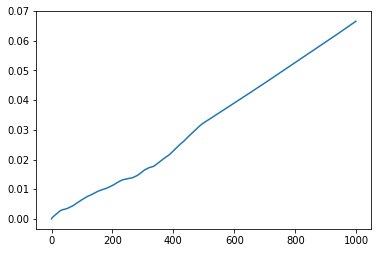

In [60]:
synthetic_variogram_GNNPL_approx_SPMINI_residuals = inter.variogram2(returnsapproxGNNPL_SPMINI_residuals.cumsum())
synthetic_variogram_GNNPL_approx_UST_residuals = inter.variogram2(returnsapproxGNNPL_UST_residuals.cumsum())
plt.plot(synthetic_variogram_GNNPL_approx_SPMINI_residuals)
plt.plot(synthetic_variogram_GNNPL_approx_UST_residuals)
% store synthetic_variogram_GNNPL_approx_SPMINI_residuals
% store synthetic_variogram_GNNPL_approx_UST_residuals